In [ ]:
'''Instruction to run our project code:
In order to run this code, you must install below packages:
numpy
matplotlib
Tensorflow
keras
skimage
six
glob
cv2
Causion: Due to the random selection of images and shuffling the resaults might be different in different run times.
'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model
from skimage import metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Add,ReLU,Conv2D,Conv2DTranspose,MaxPooling2D,BatchNormalization,Activation,AveragePooling2D,Input,
    concatenate)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
import six
from keras import backend as K
from matplotlib.pyplot import imshow
import os
 
import glob
import cv2

In [ ]:
# Augmenting training data
# ==================================================
path = '/content/drive/My Drive/data/d/bottle/'  

train_data_dir=path+'train/train_good' 
aug_path=path+'train/train_aug/aug'
if not os.path.exists(aug_path):
      os.makedirs(aug_path)
def augment_imgs(h_flip,v_flip,rot_range):

  img_height=900
  img_width=900
  batch_size=208
  nb_epochs=1
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      horizontal_flip=h_flip,
      rotation_range=rot_range,
      vertical_flip=v_flip
      ) 

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode=None,
      save_to_dir=aug_path)
  train_generator.next()

In [ ]:
augment_imgs(True,False,0)
augment_imgs(False,True,0)
for i in range(1,7):
  augment_imgs(False,False,i*5)

In [ ]:
# Initialize the parameters
# ==================================================
img_height = 256
img_width = 256
nb_epochs = 200
batch_size=32
# Load train data
# ==================================================
def get_images(path):  
    imgs=[]
    fpath= glob.glob(path, recursive=True)
    
    for fname in fpath:
      gray_img = cv2.imread(fname, 0) # load as grayscale
      resized=cv2.resize(gray_img,(img_width,img_height))
      imgs.append(resized.astype('float32') /255.)
    images = np.array(imgs)
    return images

train_img=get_images(path+'train/*/*/*.png')
test_anomaly_img=get_images(path+'test/anomaly/*/*.png')
test_good_img=get_images(path+'test/good/good/*.png')

In [ ]:
train_img=np.expand_dims(train_img, axis=-1)
test_anomaly_img=np.expand_dims(test_anomaly_img, axis=-1)
test_good_img=np.expand_dims(test_good_img, axis=-1)

In [ ]:
np.random.shuffle(train_img)
np.random.shuffle(test_anomaly_img)
np.random.shuffle(test_good_img)

In [ ]:
#The resnet network is borrowed from adnene at https://github.com/AdneneBoumessouer/MVTec-Anomaly-Detection
# ================================================== 

   
"""
@author: adnene
@inspired by: https://github.com/raghakot/keras-resnet
"""
# import tensorflow as tf
# from tensorflow import keras
import six
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Activation,
    Add,
    ReLU,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    AveragePooling2D,
    BatchNormalization,
    concatenate,
)
from tensorflow.keras.regularizers import l2
from keras import backend as K

global ROW_AXIS
global COL_AXIS
global CHANNEL_AXIS
ROW_AXIS = 1
COL_AXIS = 2
CHANNEL_AXIS = 3


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.0e-4))

    def f(input):
        conv = Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.0e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f


def _shortcut(input, residual, is_last_layer=False):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(
            filters=residual_shape[CHANNEL_AXIS],
            kernel_size=(1, 1),
            strides=(stride_width, stride_height),
            padding="valid",
            kernel_initializer="he_normal",
            kernel_regularizer=l2(1.0e-4),
        )(input)

    if is_last_layer:
        return shortcut

    return concatenate([shortcut, residual])


def _residual_block(
    block_function, filters, repetitions, is_first_layer=False, is_last_layer=False
):
    """Builds a residual block with repeating bottleneck blocks.
    """

    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(
                filters=filters,
                init_strides=init_strides,
                is_first_block_of_first_layer=(is_first_layer and i == 0),
                is_last_layer=is_last_layer,
            )(input)
        return input

    return f


def basic_block(
    filters,
    init_strides=(1, 1),
    is_first_block_of_first_layer=False,
    is_last_layer=False,
):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """

    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(
                filters=filters,
                kernel_size=(3, 3),
                strides=init_strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-4),
            )(input)
        else:
            conv1 = _bn_relu_conv(
                filters=filters, kernel_size=(3, 3), strides=init_strides
            )(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual, is_last_layer)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """

    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(
                filters=filters,
                kernel_size=(1, 1),
                strides=init_strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=l2(1e-4),
            )(input)
        else:
            conv_1_1 = _bn_relu_conv(
                filters=filters, kernel_size=(1, 1), strides=init_strides
            )(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError("Invalid {}".format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        if len(input_shape) != 3:
            raise Exception(
                "Input shape should be a tuple (nb_channels, nb_rows, nb_cols)"
            )

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(
                block_fn,
                filters=filters,
                repetitions=r,
                is_first_layer=(i == 0),
                is_last_layer=(i == 3),
            )(block)
            filters *= 2

        # Last activation
        # block = _bn_relu(block)

        model = Model(inputs=input, outputs=block)
        return model

    @staticmethod
    def build_resnet_18(input_shape):
        return ResnetBuilder.build(input_shape, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape):
        return ResnetBuilder.build(input_shape, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape):
        return ResnetBuilder.build(input_shape, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape,):
        return ResnetBuilder.build(input_shape, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape):
        return ResnetBuilder.build(input_shape, bottleneck, [3, 8, 36, 3])





In [ ]:

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Add,
    ReLU,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    BatchNormalization,
    Activation,
)
from tensorflow.keras.regularizers import l2


# Preprocessing variables
RESCALE = 1 
SHAPE = (256, 256)
PREPROCESSING_FUNCTION = None
PREPROCESSING = None
VMIN = 0.0  # -1.0
VMAX = 1.0
DYNAMIC_RANGE = VMAX - VMIN


def build_model(color_mode):
    # set channels
    if color_mode == "grayscale":
        channels = 1
    elif color_mode == "rgb":
        channels = 3

    # encoder
    resnet = ResnetBuilder.build_resnet_18((*SHAPE, channels))
    x = Conv2D(512, (1, 1), strides=1, activation="relu", padding="valid")(
        resnet.output
    )
    encoded = Conv2D(512, (1, 1), strides=1, activation="relu", padding="valid")(x)

    # decoder
    layer_1 = Conv2DTranspose(
        512, kernel_size=4, strides=2, padding="same", activation=None,
    )(encoded)
    layer_2 = BatchNormalization()(layer_1)
    layer_3 = ReLU()(layer_2)
    layer_4 = Conv2DTranspose(
        512, kernel_size=3, strides=1, padding="SAME", activation=None,
    )(layer_3)
    layer_5 = BatchNormalization()(layer_4)
    layer_6 = ReLU()(layer_5)
    ####
    add_1 = Add()([layer_1, layer_6])
    ####
    layer_7 = Conv2DTranspose(
        256, kernel_size=4, strides=2, padding="same", activation=None,
    )(add_1)
    layer_8 = BatchNormalization()(layer_7)
    layer_9 = ReLU()(layer_8)
    layer_10 = Conv2DTranspose(
        256, kernel_size=3, strides=1, padding="SAME", activation=None,
    )(layer_9)
    layer_11 = BatchNormalization()(layer_10)
    layer_12 = ReLU()(layer_11)
    ####
    add_2 = Add()([layer_7, layer_12])
    ####
    layer_13 = Conv2DTranspose(
        128, kernel_size=4, strides=2, padding="SAME", activation=None,
    )(add_2)
    layer_14 = BatchNormalization()(layer_13)
    layer_15 = ReLU()(layer_14)
    layer_16 = Conv2DTranspose(
        128, kernel_size=3, strides=1, padding="SAME", activation=None,
    )(layer_15)
    layer_17 = BatchNormalization()(layer_16)
    layer_18 = ReLU()(layer_17)
    ####
    add_3 = Add()([layer_13, layer_18])
    ####
    layer_19 = Conv2DTranspose(
        64, kernel_size=4, strides=2, padding="same", activation=None,
    )(add_3)
    layer_20 = BatchNormalization()(layer_19)
    layer_21 = ReLU()(layer_20)
    layer_22 = Conv2DTranspose(
        64, kernel_size=3, strides=1, padding="SAME", activation=None,
    )(layer_21)
    layer_23 = BatchNormalization()(layer_22)
    layer_24 = ReLU()(layer_23)
    ####
    add_4 = Add()([layer_19, layer_24])
    ####
    decoded = Conv2DTranspose(
        channels, kernel_size=4, strides=2, padding="same", activation="sigmoid",
    )(add_4)

    model = Model(resnet.input, decoded)

    return model

In [ ]:
#Define loss function, optimizer and model compilation
# ==================================================
model =build_model('grayscale')
@tf.function
def ssim_loss(gt, y_pred, max_val=1.0):
    return 1 - tf.reduce_mean(tf.image.ssim(gt, y_pred, max_val=max_val))
optimizer = tf.keras.optimizers.Adam(lr=1e-4,decay=1e-5)
model.compile(optimizer=optimizer, loss=ssim_loss)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
callbacks = [
    EarlyStopping(patience = 10, monitor = 'val_loss'),
    ModelCheckpoint('Anomaly_Detect_bottle.h5', verbose=1, save_best_only = True)]

history = model.fit(train_img,train_img, validation_split = 0.05, batch_size = 32, epochs = 200 ,callbacks=callbacks)

Epoch 1/200
56/56 [==============================] - ETA: 0s - loss: 1.1690
Epoch 00001: val_loss improved from inf to 1.12911, saving model to Anomaly_Detect_bottle.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


56/56 [==============================] - 98s 1s/step - loss: 1.1690 - val_loss: 1.1291
Epoch 2/200
56/56 [==============================] - ETA: 0s - loss: 0.7512
Epoch 00002: val_loss improved from 1.12911 to 1.01465, saving model to Anomaly_Detect_bottle.h5
56/56 [==============================] - 47s 845ms/step - loss: 0.7512 - val_loss: 1.0147
Epoch 3/200
56/56 [==============================] - ETA: 0s - loss: 0.6912
Epoch 00003: val_loss improved from 1.01465 to 0.94670, saving model to Anomaly_Detect_bottle.h5
56/56 [==============================] - 47s 834ms/step - loss: 0.6912 - val_loss: 0.9467
Epoch 4/200
56/56 [==============================] - ETA: 0s - loss: 0.6541
Epoch 00004: val_loss improved from 0.94670 to 0.86222, saving model to Anomaly_Detect_bottle.h5
56/56 [==============================] - 47s 835ms/step - loss: 0.6541 - val_loss: 0.8622
Epoch 5/200
56/56 [==============================] - ETA: 0s - loss: 0.6251
Epoch 00005: val_loss improved from 0.86222 to 0

In [ ]:
history1 = model.fit(train_img,train_img, validation_split = 0.05, batch_size = 32, epochs = 20 ,callbacks=callbacks)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 0.0210
Epoch 00001: val_loss did not improve from 0.03229
56/56 [==============================] - 46s 825ms/step - loss: 0.0210 - val_loss: 0.0325
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 0.0203
Epoch 00002: val_loss did not improve from 0.03229
56/56 [==============================] - 46s 818ms/step - loss: 0.0203 - val_loss: 0.0333
Epoch 3/20
56/56 [==============================] - ETA: 0s - loss: 0.0203
Epoch 00003: val_loss did not improve from 0.03229
56/56 [==============================] - 46s 817ms/step - loss: 0.0203 - val_loss: 0.0332
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 0.0199
Epoch 00004: val_loss did not improve from 0.03229
56/56 [==============================] - 46s 827ms/step - loss: 0.0199 - val_loss: 0.0345
Epoch 5/20
56/56 [==============================] - ETA: 0s - loss: 0.0197
Epoch 00005: val_loss improved from 0.03229 to 0.03227, savin

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


56/56 [==============================] - 47s 831ms/step - loss: 0.0197 - val_loss: 0.0323
Epoch 6/20
56/56 [==============================] - ETA: 0s - loss: 0.0205
Epoch 00006: val_loss did not improve from 0.03227
56/56 [==============================] - 46s 819ms/step - loss: 0.0205 - val_loss: 0.0369
Epoch 7/20
56/56 [==============================] - ETA: 0s - loss: 0.0206
Epoch 00007: val_loss did not improve from 0.03227
56/56 [==============================] - 46s 818ms/step - loss: 0.0206 - val_loss: 0.0341
Epoch 8/20
56/56 [==============================] - ETA: 0s - loss: 0.0212
Epoch 00008: val_loss improved from 0.03227 to 0.03191, saving model to Anomaly_Detect_bottle.h5
56/56 [==============================] - 47s 840ms/step - loss: 0.0212 - val_loss: 0.0319
Epoch 9/20
56/56 [==============================] - ETA: 0s - loss: 0.0205
Epoch 00009: val_loss did not improve from 0.03191
56/56 [==============================] - 46s 826ms/step - loss: 0.0205 - val_loss: 0.0327


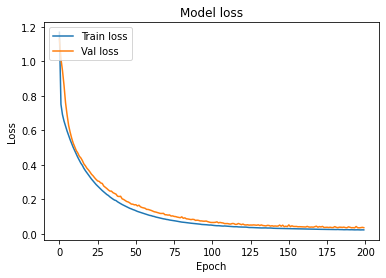

In [ ]:
#Plot the training history
# ==================================================
def plot_losses():
    
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Val loss'], loc='upper left')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
plot_losses())

In [ ]:
val_good=test_good_img[0:8,:,:,:]
test_good=test_good_img[8:20,:,:,:]
val_anomaly=test_anomaly_img[0:20,:,:,:]
test_anomaly=test_anomaly_img[20:64,:,:,:]

In [ ]:
#predict the train, validation and test data
# ==================================================
train_pred = model.predict(train_img)
val_good_pred = model.predict(val_good)
val_anomaly_pred = model.predict(val_anomaly)
test_good_pred = model.predict(test_good)
test_anomaly_pred = model.predict(test_anomaly)


In [ ]:
# Some parts of the code are inspired by https://github.com/Elaine0
def get_l2_ssim(original, reconstructed):
    original=np.mean(original, axis=-1)
    reconstructed = np.mean(reconstructed,axis=-1)
    (ssim_score, ssim_mask) =metrics.structural_similarity(original, reconstructed, full=True)
    L2_mask = (original-reconstructed)**2
    L2_score = np.mean(L2_mask)
    return 1-ssim_score, 1-ssim_mask,L2_score, L2_mask

def normalize(data1, data2):
    tot_max = max(max(data1), max(data2))
    tot_min = min(min(data1), min(data2))
    return (data1 - tot_min) / (tot_max - tot_min), (data2 - tot_min) / (tot_max - tot_min)


In [ ]:
def get_score_array(images,images_pred):
    l2_arr = []
    ssim_arr = []

    for i in range(len(images)):
        ssim, _ ,l2, _= get_l2_ssim(images[i], images_pred[i])
        ssim_arr.append(ssim)
        l2_arr.append(l2)
    return ssim_arr, l2_arr

anomaly_val_ssim,anomaly_val_l2=get_score_array(val_anomaly,val_anomaly_pred)
good_val_ssim,good_val_l2=get_score_array(val_good,val_good_pred)

In [ ]:
good_val_l2_norm, anomaly_val_l2_norm = normalize(good_val_l2, anomaly_val_l2)
good_val_ssim_norm, anomaly_val_ssim_norm = normalize(good_val_ssim, anomaly_val_ssim)

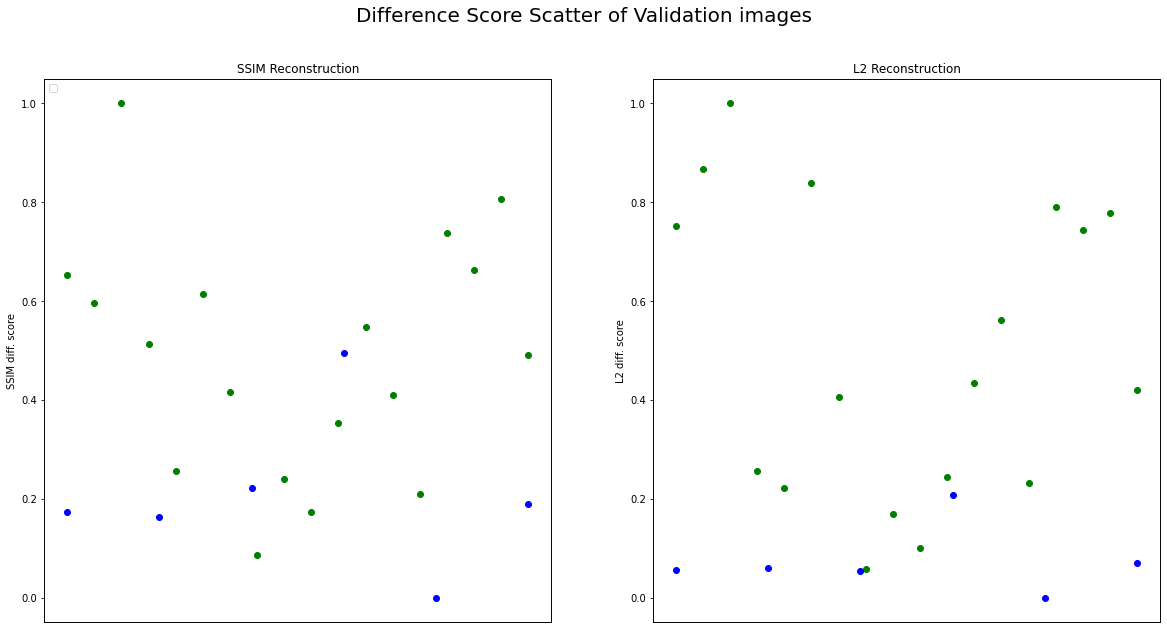

In [ ]:
fig, ax= plt.subplots(1,2,figsize=(20,10)) #ssim
fig.suptitle('Difference Score Scatter of Validation images', fontsize=20)

ax[0].set_title("SSIM Reconstruction")
ax[0].set_ylabel('SSIM diff. score')
ax[0].legend(['Train loss', 'Val loss'], loc='upper left')
ax[0].scatter(range(1,len(anomaly_val_ssim_norm)+1), anomaly_val_ssim_norm, c='green')
ax0 = ax[0].twiny()
ax0.scatter(range(1,len(good_val_ssim_norm)+1), good_val_ssim_norm, c='blue')
ax[0].axes.get_xaxis().set_visible(False)
ax0.axes.get_xaxis().set_visible(False)

ax[1].set_title("L2 Reconstruction")
ax[1].set_ylabel('L2 diff. score')
ax[1].scatter(range(1,len(anomaly_val_l2_norm)+1), anomaly_val_l2_norm, c='green')
ax1 = ax[1].twiny()
ax1.scatter(range(1,len(good_val_l2_norm)+1), good_val_l2_norm, c='blue')
ax[1].axes.get_xaxis().set_visible(False)
ax1.axes.get_xaxis().set_visible(False)


In [ ]:
#Fine tuning the threshold

def num_errors(good_data, anomaly_data, t):
    false_positive = np.count_nonzero((good_data - t > 0))
    false_negative =  np.count_nonzero((anomaly_data - t < 0))
    return false_positive + false_negative


def find_threshold(good_data, anomaly_data):
  threshold = np.linspace(0.4,0,100)
  best_threshold = []
  min_error = float('inf')

  for t in threshold:
      error = num_errors(good_data, anomaly_data, t)
      if error < min_error:
        min_error = error

  for t in threshold:
      if num_errors(good_data, anomaly_data, t) == min_error:
          best_threshold.append(t)
  
  return np.mean(best_threshold)
 

In [ ]:
ssim_thresh = find_threshold(good_val_ssim_norm, anomaly_val_ssim_norm)
l2_thresh = find_threshold(good_val_l2_norm, anomaly_val_l2_norm)

anomaly_test_ssim_scores,anomaly_test_l2_scores=get_score_array(test_anomaly,test_anomaly_pred)
good_test_ssim_scores,good_test_l2_scores=get_score_array(test_good,test_good_pred)

good_test_l2_norm, anomaly_test_l2_norm = normalize(good_test_l2_scores, anomaly_test_l2_scores)
good_test_ssim_norm, anomaly_test_ssim_norm = normalize(good_test_ssim_scores, anomaly_test_ssim_scores)

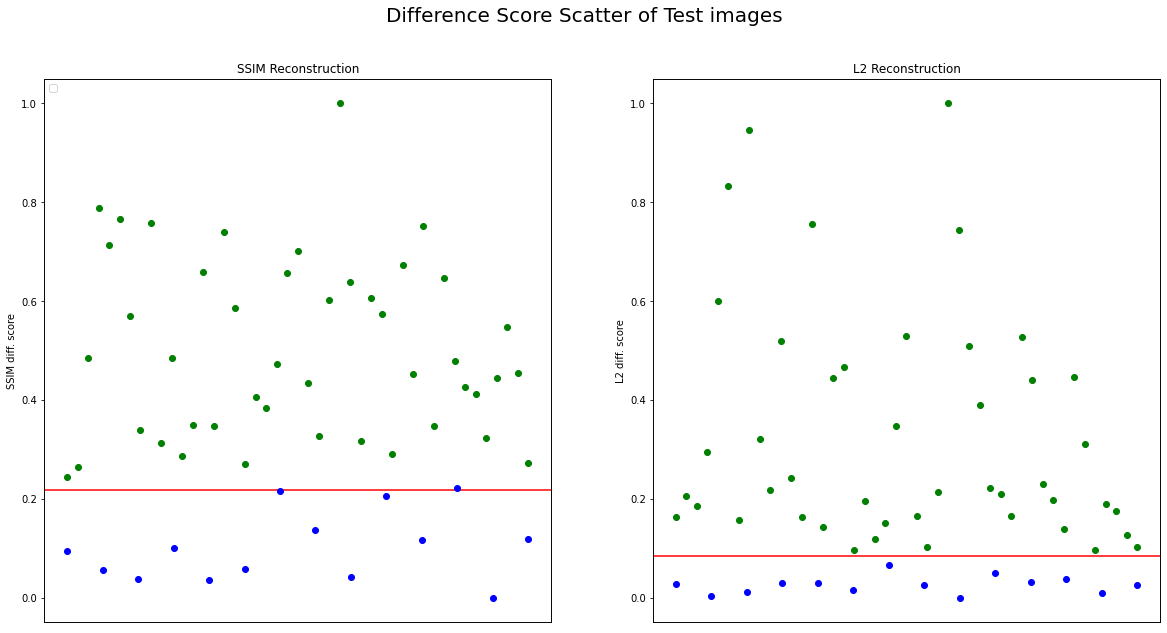

In [ ]:
fig_test, ax_test= plt.subplots(1,2,figsize=(20,10)) #ssim
fig_test.suptitle('Difference Score Scatter of Test images', fontsize=20)

ax_test[0].set_title("SSIM Reconstruction")
ax_test[0].set_ylabel('SSIM diff. score')
ax_test[0].legend(['Train loss', 'Val loss'], loc='upper left')
ax_test[0].scatter(range(1,len(anomaly_test_ssim_norm)+1), anomaly_test_ssim_norm, c='green')
ax_test0 = ax_test[0].twiny()
ax_test0.scatter(range(1,len(good_test_ssim_norm)+1), good_test_ssim_norm, c='blue')
ax_test[0].axhline(y=ssim_thresh, color='r', linestyle='-')
ax_test[0].axes.get_xaxis().set_visible(False)
ax_test0.axes.get_xaxis().set_visible(False)

ax_test[1].set_title("L2 Reconstruction")
ax_test[1].set_ylabel('L2 diff. score')
ax_test[1].scatter(range(1,len(anomaly_test_l2_norm)+1), anomaly_test_l2_norm, c='green')
ax_test1 = ax_test[1].twiny()
ax_test1.scatter(range(1,len(good_test_l2_norm)+1), good_test_l2_norm, c='blue')
ax_test[1].axhline(y=l2_thresh, color='r', linestyle='-')
ax_test[1].axes.get_xaxis().set_visible(False)
ax_test1.axes.get_xaxis().set_visible(False)

In [ ]:
from sklearn.metrics import f1_score

ssim_pred = np.concatenate(((good_test_ssim_norm < ssim_thresh), (anomaly_test_ssim_norm  < ssim_thresh))) * 1
ssim_true = np.concatenate((np.ones_like(good_test_ssim_norm, dtype=int),np.zeros_like(anomaly_test_ssim_norm, dtype=int)))

l2_pred = np.concatenate(((good_test_l2_norm < l2_thresh), (anomaly_test_l2_norm  < l2_thresh))) * 1
l2_true = np.concatenate((np.ones_like(good_test_l2_norm, dtype=int),np.zeros_like(anomaly_test_l2_norm, dtype=int)))

print("SSIM Difference Metric F1 Score: ", f1_score(ssim_true, ssim_pred))
print("L2 Difference Metric F1 Score: ", f1_score(l2_true, l2_pred))
#Causion: Due to the random selection of images and shuffling the resaults might be different in different run times.

SSIM Difference Metric F1 Score:  0.962962962962963
L2 Difference Metric F1 Score:  1.0
